In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
%load_ext tensorboard

hyperparam_tunning = True

In [81]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc

def features_correlation(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals, _ = chi2(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()

In [82]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))

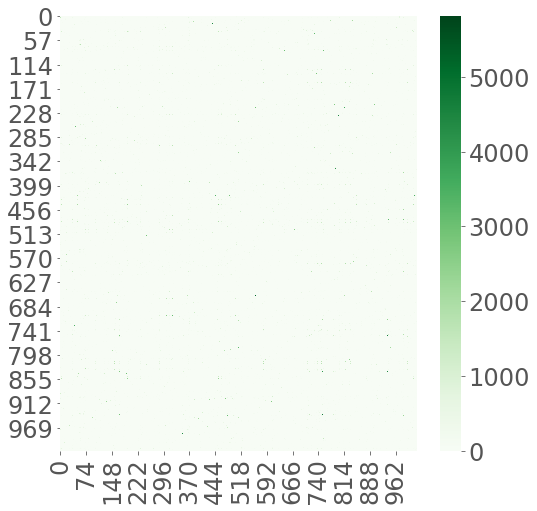

In [83]:
features_correlation(features_shared)

In [84]:
feat_select = SelectPercentile(chi2, percentile=10)
shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
only_2c9_reduced = feat_select.transform(features_only_2c9)
only_3a4_reduced = feat_select.transform(features_only_3a4)

threshold = 0.9
sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
features_shared = sel.fit_transform(features_shared)
features_only_2c9 = sel.transform(features_only_2c9)
features_only_3a4 = sel.transform(features_only_3a4)

combined_filters = VarianceThreshold(threshold=(threshold * (1 - threshold)))
shared_reduced_comb = combined_filters.fit_transform(shared_reduced)
only_2c9_reduced_comb = combined_filters.transform(only_2c9_reduced)
only_3a4_reduced_comb = combined_filters.transform(only_3a4_reduced)

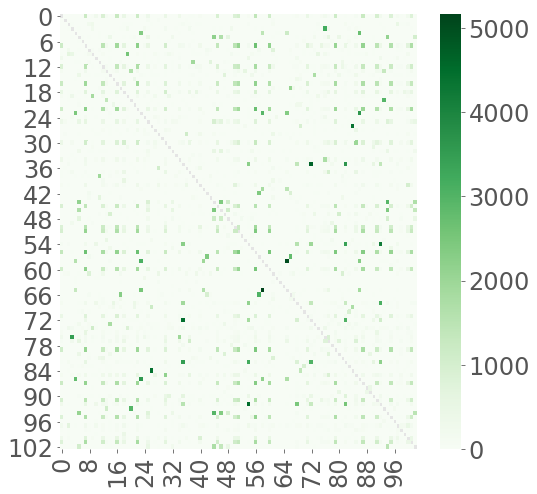

In [85]:
features_correlation(shared_reduced)

We try selecting the top features, moving the percentile value

In [58]:
hidden_layers = 4
neurons = 40
dropout = 0.2
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.Adam()
L2 = 0.010000
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 52 features
NER: 0.702, Sensitivity or recall: 0.503, Specificity: 0.900, Precision: 0.704, Correctly calssified: 0.772, MCC: 0.448
Testing
NER: 0.617, Sensitivity or recall: 0.365, Specificity: 0.869, Precision: 0.611, Correctly calssified: 0.687, MCC: 0.273
Validation set with 10 percentile, 103 features
NER: 0.729, Sensitivity or recall: 0.546, Specificity: 0.912, Precision: 0.745, Correctly calssified: 0.794, MCC: 0.504
Testing
NER: 0.652, Sensitivity or recall: 0.420, Specificity: 0.884, Precision: 0.672, Correctly calssified: 0.717, MCC: 0.350
Validation set with 15 percentile, 154 features
NER: 0.762, Sensitivity or recall: 0.647, Specificity: 0.876, Precision: 0.712, Correctly calssified: 0.803, MCC: 0.538
Testing
NER: 0.704, Sensitivity or recall: 0.584, Specificity: 0.824, Precision: 0.652, Correctly calssified: 0.737, MCC: 0.419
Validation set with 20 percentile, 205 features
NER: 0.779, Sensitivity or recall: 0.720, Specificity: 0.837, Prec

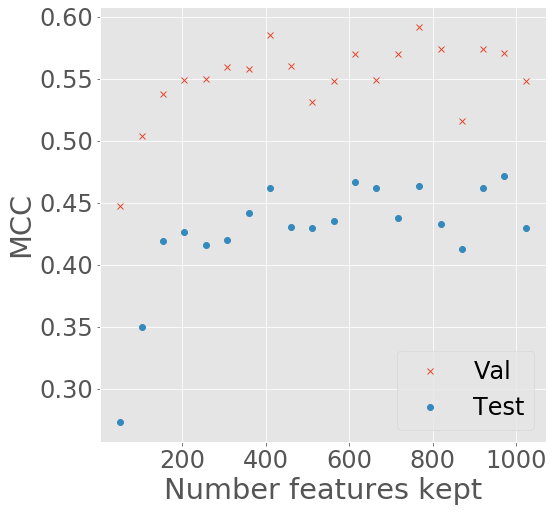

In [59]:
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 52 features
NER: 0.714, Sensitivity or recall: 0.552, Specificity: 0.876, Precision: 0.679, Correctly calssified: 0.772, MCC: 0.455
Testing
NER: 0.642, Sensitivity or recall: 0.447, Specificity: 0.838, Precision: 0.609, Correctly calssified: 0.697, MCC: 0.310
Validation set with 10 percentile, 103 features
NER: 0.743, Sensitivity or recall: 0.602, Specificity: 0.884, Precision: 0.710, Correctly calssified: 0.793, MCC: 0.510
Testing
NER: 0.675, Sensitivity or recall: 0.531, Specificity: 0.819, Precision: 0.624, Correctly calssified: 0.715, MCC: 0.365
Validation set with 15 percentile, 154 features
NER: 0.761, Sensitivity or recall: 0.635, Specificity: 0.887, Precision: 0.727, Correctly calssified: 0.806, MCC: 0.542
Testing
NER: 0.712, Sensitivity or recall: 0.599, Specificity: 0.825, Precision: 0.659, Correctly calssified: 0.743, MCC: 0.434
Validation set with 20 percentile, 205 features
NER: 0.782, Sensitivity or recall: 0.675, Specificity: 0.888, Prec

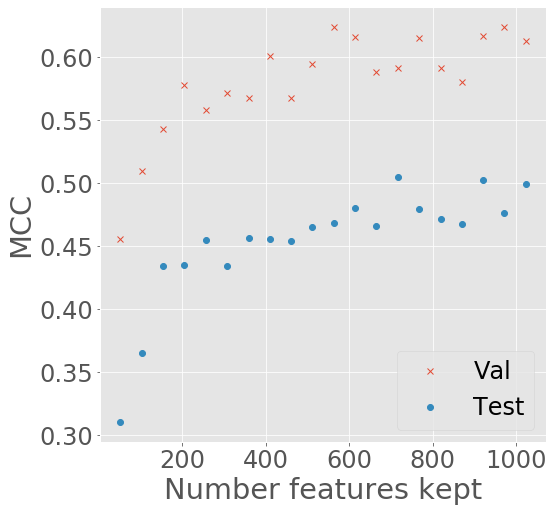

In [60]:
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = SVC(C=8, kernel="rbf")
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 52 features
Testing
Validation set with 10 percentile, 103 features
Testing
Validation set with 15 percentile, 154 features
Testing
Validation set with 20 percentile, 205 features
Testing
Validation set with 25 percentile, 256 features
Testing
Validation set with 30 percentile, 307 features
Testing
Validation set with 35 percentile, 359 features
Testing
Validation set with 40 percentile, 410 features
Testing
Validation set with 45 percentile, 460 features
Testing
Validation set with 50 percentile, 512 features
Testing
Validation set with 55 percentile, 563 features
Testing
Validation set with 60 percentile, 614 features
Testing
Validation set with 65 percentile, 665 features
Testing
Validation set with 70 percentile, 717 features
Testing
Validation set with 75 percentile, 768 features
Testing
Validation set with 80 percentile, 819 features
Testing
Validation set with 85 percentile, 870 features
Testing
Validation set with 90 percentile, 921 features
Te

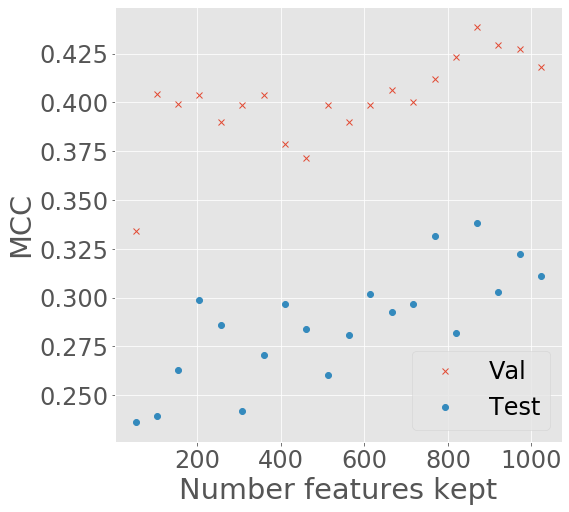

In [62]:
from sklearn.neighbors import KNeighborsClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = KNeighborsClassifier()
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 52 features
Testing
Validation set with 10 percentile, 103 features
Testing
Validation set with 15 percentile, 154 features
Testing
Validation set with 20 percentile, 205 features
Testing
Validation set with 25 percentile, 256 features
Testing
Validation set with 30 percentile, 307 features
Testing
Validation set with 35 percentile, 359 features
Testing
Validation set with 40 percentile, 410 features
Testing
Validation set with 45 percentile, 460 features
Testing
Validation set with 50 percentile, 512 features
Testing
Validation set with 55 percentile, 563 features
Testing
Validation set with 60 percentile, 614 features
Testing
Validation set with 65 percentile, 665 features
Testing
Validation set with 70 percentile, 717 features
Testing
Validation set with 75 percentile, 768 features
Testing
Validation set with 80 percentile, 819 features
Testing
Validation set with 85 percentile, 870 features
Testing
Validation set with 90 percentile, 921 features
Te

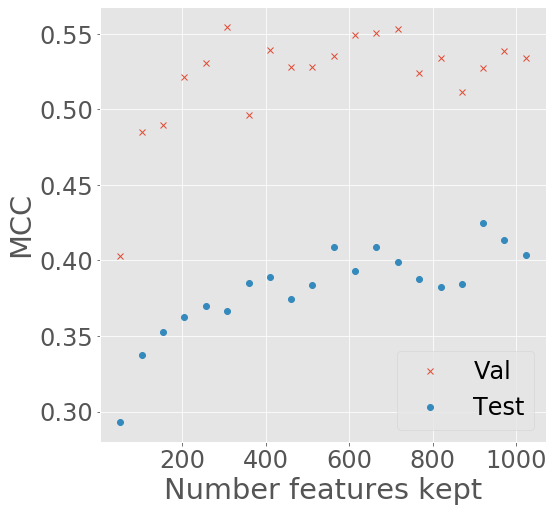

In [63]:
from sklearn.ensemble import RandomForestClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = RandomForestClassifier()
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Now we filter features according to variance, given that the input is binary, we use the variance formula for the Bernouilli probability distribution v=p*(1-p)

In [52]:
percentiles = [0.1*i for i in range(1, 10)]
MCCs = []
MCC_test = []
for percentile in percentiles:
    sel = VarianceThreshold(threshold=(percentile * (1 - percentile)))
    try:
        shared_reduced = sel.fit_transform(features_shared)
    except ValueError:
        MCCs.append(np.nan)
        MCC_test.append(np.nan)
        continue
    only_2c9_reduced = sel.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 0.1 percentile, 67 features
NER: 0.757, Sensitivity or recall: 0.667, Specificity: 0.847, Precision: 0.673, Correctly calssified: 0.789, MCC: 0.515
Testing
NER: 0.683, Sensitivity or recall: 0.552, Specificity: 0.815, Precision: 0.628, Correctly calssified: 0.720, MCC: 0.378
Validation set with 0.2 percentile, 25 features
NER: 0.655, Sensitivity or recall: 0.383, Specificity: 0.926, Precision: 0.711, Correctly calssified: 0.752, MCC: 0.382
Testing
NER: 0.591, Sensitivity or recall: 0.290, Specificity: 0.891, Precision: 0.602, Correctly calssified: 0.674, MCC: 0.230
Validation set with 0.30000000000000004 percentile, 13 features
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.4 percentile, 5 features
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.6000000000000001 percentile, 5 features
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.7000000000000001 percentile, 13 features
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.8 percentile, 25 features
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.9 percentile, 67 features
NER: 0.694, Sensitivity or recall: 0.481, Specificity: 0.907, Precision: 0.711, Correctly calssified: 0.770, MCC: 0.440
Testing
NER: 0.650, Sensitivity or recall: 0.416, Specificity: 0.883, Precision: 0.668, Correctly calssified: 0.715, MCC: 0.344


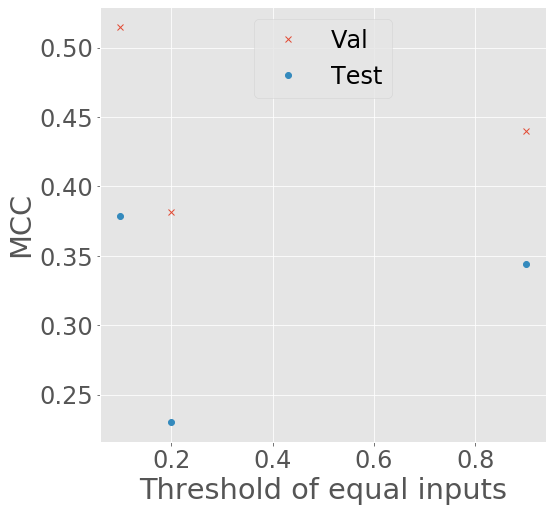

In [54]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Threshold of equal inputs")
plt.legend(loc="upper center")

We now combine the two feature selectors, setting the variance one at threshold 0.1

In [55]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    shared_reduced = sel.fit_transform(shared_reduced)
    only_2c9_reduced = sel.transform(only_2c9_reduced)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 21 features
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 10 percentile, 29 features
NER: 0.672, Sensitivity or recall: 0.435, Specificity: 0.909, Precision: 0.693, Correctly calssified: 0.756, MCC: 0.399
Testing
NER: 0.602, Sensitivity or recall: 0.336, Specificity: 0.868, Precision: 0.590, Correctly calssified: 0.676, MCC: 0.242
Validation set with 15 percentile, 35 features
NER: 0.715, Sensitivity or recall: 0.568, Specificity: 0.861, Precision: 0.660, Correctly calssified: 0.767, MCC: 0.448
Testing
NER: 0.648, Sensitivity or recall: 0.489, Specificity: 0.807, Precision: 0.590, Correctly calssified: 0.692, MCC: 0.311
Validation set with 20 percentile, 40 features
NER: 0.716, Sensitivity or recall: 0.572, Specificity: 0.860, Precision: 0.659, Correctly calssified: 0.767, MCC: 0.450
Testing
NER: 0.637, Sensitivity or recall: 0.468, Specificity: 0.806, Precision: 0.576, Correctly calssified: 0.684, MCC: 0.288

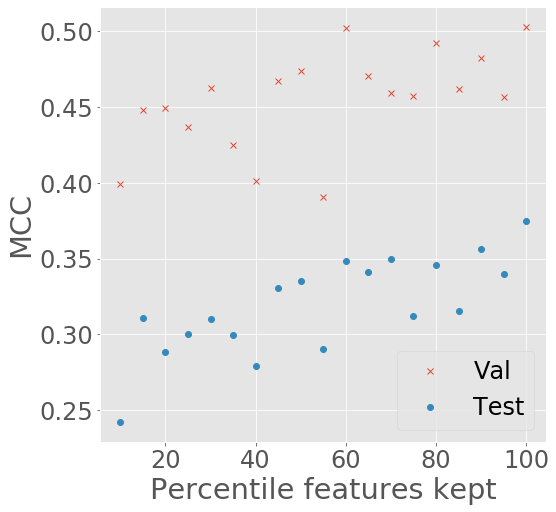

In [56]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

We repeat the same with a SVM model

Validation set with 5 percentile, 21 features
NER: 0.671, Sensitivity or recall: 0.464, Specificity: 0.879, Precision: 0.644, Correctly calssified: 0.745, MCC: 0.379
Testing
NER: 0.611, Sensitivity or recall: 0.368, Specificity: 0.853, Precision: 0.586, Correctly calssified: 0.678, MCC: 0.254
Validation set with 10 percentile, 29 features
NER: 0.676, Sensitivity or recall: 0.464, Specificity: 0.889, Precision: 0.665, Correctly calssified: 0.752, MCC: 0.395
Testing
NER: 0.609, Sensitivity or recall: 0.378, Specificity: 0.840, Precision: 0.572, Correctly calssified: 0.673, MCC: 0.246
Validation set with 15 percentile, 35 features
NER: 0.706, Sensitivity or recall: 0.536, Specificity: 0.876, Precision: 0.672, Correctly calssified: 0.767, MCC: 0.441
Testing
NER: 0.647, Sensitivity or recall: 0.458, Specificity: 0.836, Precision: 0.612, Correctly calssified: 0.699, MCC: 0.318
Validation set with 20 percentile, 40 features
NER: 0.714, Sensitivity or recall: 0.565, Specificity: 0.863, Precisi

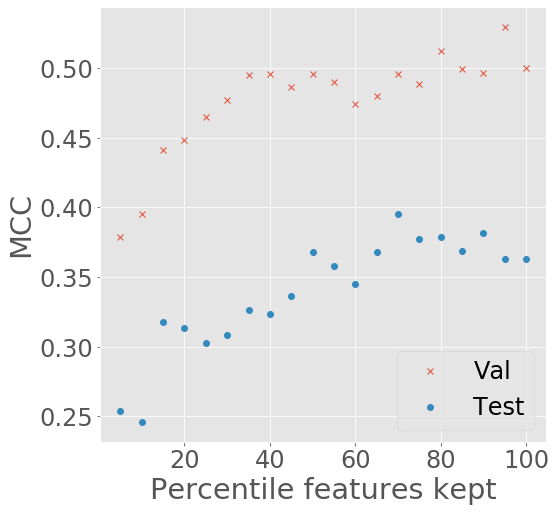

In [57]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    shared_reduced = sel.fit_transform(shared_reduced)
    only_2c9_reduced = sel.transform(only_2c9_reduced)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    svm = SVC(C=8, kernel="rbf")
    svm.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = svm.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = svm.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

In [19]:
print(features_shared.shape, features_only_2c9.shape, features_only_3a4.shape)
print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)

(9420, 67) (2813, 67) (2994, 67)
(9420, 103) (2813, 103) (2994, 103)
(9420, 30) (2813, 30) (2994, 30)


In [30]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [7]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(2, 6))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete(list(range(10, 61, 10))))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

os.makedirs("hyperparameters_tunning/morgan_fingerprints_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy')])
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=10, verbose=2)
    _, results = model.evaluate(test_data, test_labels)
    return results

def run(run_dir, hparams):
      if os.path.exists(run_dir):
        return
      with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar("accuracy", accuracy, step=1)

In [8]:
if hyperparam_tunning:
    session_num = 0
    total_runs = len(HP_NEURONS.domain.values)*len(HP_HIDDEN_LAYERS.domain.values)*len([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value])*len(HP_OPTIMIZER.domain.values)*len([HP_L2.domain.min_value, HP_L2.domain.max_value])*len(HP_LR.domain.values)
    looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0  of 1440
{'neurons': 10, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
---Starting trial: run_1  of 1440
{'neurons': 10, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
---Starting trial: run_2  of 1440
{'neurons': 10, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
---Starting trial: run_3  of 1440
{'neurons': 10, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
---Starting trial: run_4  of 1440
{'neurons': 10, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
---Starting trial: run_5  of 1440
{'neurons': 10, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
---Starting trial: run_6  of 1440
{'neurons': 10, 'hi

---Starting trial: run_248  of 1440
{'neurons': 20, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
---Starting trial: run_249  of 1440
{'neurons': 20, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
---Starting trial: run_250  of 1440
{'neurons': 20, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
---Starting trial: run_251  of 1440
{'neurons': 20, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
---Starting trial: run_252  of 1440
{'neurons': 20, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
---Starting trial: run_253  of 1440
{'neurons': 20, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
---Starting trial: run_254  of 1440
{'neurons': 20, 'hid

---Starting trial: run_616  of 1440
{'neurons': 30, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
---Starting trial: run_617  of 1440
{'neurons': 30, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
---Starting trial: run_618  of 1440
{'neurons': 30, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
---Starting trial: run_619  of 1440
{'neurons': 30, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
---Starting trial: run_620  of 1440
{'neurons': 30, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
---Starting trial: run_621  of 1440
{'neurons': 30, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
---Starting trial: run_622  of 1440
{'neurons': 30, 'hidden_layer

Epoch 1/10
221/221 - 1s - loss: 10743172.0000 - binary_accuracy: 0.6065
Epoch 2/10
221/221 - 1s - loss: 2131297.5000 - binary_accuracy: 0.6078
Epoch 3/10
221/221 - 1s - loss: 10364.8359 - binary_accuracy: 0.6014
Epoch 4/10
221/221 - 1s - loss: 10181.6973 - binary_accuracy: 0.6133
Epoch 5/10
221/221 - 1s - loss: 10014.3613 - binary_accuracy: 0.5956
Epoch 6/10
221/221 - 1s - loss: 9855.3418 - binary_accuracy: 0.5830
Epoch 7/10
221/221 - 1s - loss: 9700.7920 - binary_accuracy: 0.5977
Epoch 8/10
221/221 - 1s - loss: 9548.9277 - binary_accuracy: 0.6166
Epoch 9/10
221/221 - 1s - loss: 9398.4492 - binary_accuracy: 0.6156
Epoch 10/10
221/221 - 1s - loss: 9248.5225 - binary_accuracy: 0.6218
74/74 [==============================] - 0s 2ms/step - loss: 9173.1758 - binary_accuracy: 0.6786
---Starting trial: run_825  of 1440
{'neurons': 40, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.6960 - binary_accurac

Epoch 1/10
221/221 - 1s - loss: 0.6755 - binary_accuracy: 0.6895
Epoch 2/10
221/221 - 1s - loss: 0.5847 - binary_accuracy: 0.7171
Epoch 3/10
221/221 - 1s - loss: 0.5425 - binary_accuracy: 0.7362
Epoch 4/10
221/221 - 1s - loss: 0.5398 - binary_accuracy: 0.7346
Epoch 5/10
221/221 - 1s - loss: 0.5229 - binary_accuracy: 0.7489
Epoch 6/10
221/221 - 1s - loss: 0.5148 - binary_accuracy: 0.7507
Epoch 7/10
221/221 - 1s - loss: 0.5074 - binary_accuracy: 0.7621
Epoch 8/10
221/221 - 1s - loss: 0.5049 - binary_accuracy: 0.7554
Epoch 9/10
221/221 - 1s - loss: 0.4970 - binary_accuracy: 0.7631
Epoch 10/10
221/221 - 1s - loss: 0.4990 - binary_accuracy: 0.7537
74/74 [==============================] - 0s 2ms/step - loss: 0.5024 - binary_accuracy: 0.7473
---Starting trial: run_834  of 1440
{'neurons': 40, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6723
Epoch 2/10
221/221 - 1s - loss: nan -

Epoch 4/10
221/221 - 1s - loss: 0.6493 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.6496 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.6492 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.6487 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.6493 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.6489 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.6480 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.6467 - binary_accuracy: 0.6786
---Starting trial: run_843  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 834169.6250 - binary_accuracy: 0.6344
Epoch 2/10
221/221 - 1s - loss: 1144.0096 - binary_accuracy: 0.6328
Epoch 3/10
221/221 - 1s - loss: 4.5178 - binary_accuracy: 0.6524
Epoch 4/10
221/221 - 1s - loss: 5135.1836 - binary_accuracy: 0.6450
Epoch 5/10
221/221 -

Epoch 3/10
221/221 - 1s - loss: 0.4962 - binary_accuracy: 0.7660
Epoch 4/10
221/221 - 1s - loss: 0.4854 - binary_accuracy: 0.7713
Epoch 5/10
221/221 - 1s - loss: 0.4782 - binary_accuracy: 0.7744
Epoch 6/10
221/221 - 1s - loss: 0.4670 - binary_accuracy: 0.7854
Epoch 7/10
221/221 - 1s - loss: 0.4568 - binary_accuracy: 0.7946
Epoch 8/10
221/221 - 1s - loss: 0.4421 - binary_accuracy: 0.8004
Epoch 9/10
221/221 - 1s - loss: 0.4384 - binary_accuracy: 0.8048
Epoch 10/10
221/221 - 1s - loss: 0.4314 - binary_accuracy: 0.8051
74/74 [==============================] - 0s 2ms/step - loss: 0.4752 - binary_accuracy: 0.7873
---Starting trial: run_852  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.8200 - binary_accuracy: 0.6749
Epoch 2/10
221/221 - 1s - loss: 0.5951 - binary_accuracy: 0.6735
Epoch 3/10
221/221 - 1s - loss: 0.5925 - binary_accuracy: 0.6756
Epoch 4/10
221/221 - 1s - loss: 0.

Epoch 3/10
221/221 - 1s - loss: 0.8170 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.8111 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.8095 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.8059 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.8056 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.8041 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.8024 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.8009 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.7985 - binary_accuracy: 0.6786
---Starting trial: run_861  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.8376 - binary_accuracy: 0.6251
Epoch 2/10
221/221 - 1s - loss: 0.8050 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.7981 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.

221/221 - 1s - loss: nan - binary_accuracy: 0.5915
Epoch 6/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6031
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5994
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5953
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5983
Epoch 10/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6110
74/74 [==============================] - 0s 2ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_870  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7167 - binary_accuracy: 0.6890
Epoch 2/10
221/221 - 1s - loss: 0.6145 - binary_accuracy: 0.7217
Epoch 3/10
221/221 - 1s - loss: 0.5763 - binary_accuracy: 0.7390
Epoch 4/10
221/221 - 1s - loss: 0.5568 - binary_accuracy: 0.7464
Epoch 5/10
221/221 - 1s - loss: 0.5352 - binary_accuracy: 0.7607
Epoch 6/10
221/221 - 1s - loss: 0.5314 - binary_accuracy: 0.7

Epoch 5/10
221/221 - 1s - loss: 2.5336 - binary_accuracy: 0.6402
Epoch 6/10
221/221 - 1s - loss: 2.5339 - binary_accuracy: 0.6476
Epoch 7/10
221/221 - 1s - loss: 2.5354 - binary_accuracy: 0.6467
Epoch 8/10
221/221 - 1s - loss: 2.5327 - binary_accuracy: 0.6408
Epoch 9/10
221/221 - 1s - loss: 2.5310 - binary_accuracy: 0.6425
Epoch 10/10
221/221 - 1s - loss: 2.5344 - binary_accuracy: 0.6461
74/74 [==============================] - 0s 2ms/step - loss: 2.5311 - binary_accuracy: 0.6786
---Starting trial: run_879  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: 5653186740224.0000 - binary_accuracy: 0.5734
Epoch 2/10
221/221 - 1s - loss: 184460492800.0000 - binary_accuracy: 0.5673
Epoch 3/10
221/221 - 1s - loss: 10675987.0000 - binary_accuracy: 0.5638
Epoch 4/10
221/221 - 1s - loss: 1045680448.0000 - binary_accuracy: 0.5670
Epoch 5/10
221/221 - 1s - loss: 18483076.0000 - binary_ac

221/221 - 1s - loss: 0.6311 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.6301 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.6300 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.6294 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.6298 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.6301 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.6309 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 3ms/step - loss: 0.6308 - binary_accuracy: 0.6786
---Starting trial: run_888  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 1850.8191 - binary_accuracy: 0.6514
Epoch 2/10
221/221 - 1s - loss: 108.0564 - binary_accuracy: 0.6747
Epoch 3/10
221/221 - 2s - loss: 93.0887 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 2s - loss: 1593.3627 - binary_accuracy: 0.6510
Epoch 5/10
221/221 - 1s - loss: 85.62

Epoch 5/10
221/221 - 1s - loss: 0.7725 - binary_accuracy: 0.6795
Epoch 6/10
221/221 - 1s - loss: 0.7651 - binary_accuracy: 0.6812
Epoch 7/10
221/221 - 1s - loss: 0.7547 - binary_accuracy: 0.6872
Epoch 8/10
221/221 - 1s - loss: 0.7427 - binary_accuracy: 0.6965
Epoch 9/10
221/221 - 1s - loss: 0.7336 - binary_accuracy: 0.7077
Epoch 10/10
221/221 - 1s - loss: 0.7248 - binary_accuracy: 0.7053
74/74 [==============================] - 0s 2ms/step - loss: 0.6861 - binary_accuracy: 0.7389
---Starting trial: run_897  of 1440
{'neurons': 40, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.7848 - binary_accuracy: 0.6766
Epoch 2/10
221/221 - 1s - loss: 0.7189 - binary_accuracy: 0.7064
Epoch 3/10
221/221 - 1s - loss: 0.6722 - binary_accuracy: 0.7243
Epoch 4/10
221/221 - 1s - loss: 0.6478 - binary_accuracy: 0.7372
Epoch 5/10
221/221 - 1s - loss: 0.6269 - binary_accuracy: 0.7507
Epoch 6/10
221/221 - 1s - loss: 0.61

Epoch 5/10
221/221 - 1s - loss: 0.5155 - binary_accuracy: 0.7785
Epoch 6/10
221/221 - 1s - loss: 0.5061 - binary_accuracy: 0.7803
Epoch 7/10
221/221 - 1s - loss: 0.4900 - binary_accuracy: 0.7916
Epoch 8/10
221/221 - 1s - loss: 0.4829 - binary_accuracy: 0.7935
Epoch 9/10
221/221 - 1s - loss: 0.4678 - binary_accuracy: 0.7929
Epoch 10/10
221/221 - 1s - loss: 0.4523 - binary_accuracy: 0.8146
74/74 [==============================] - 0s 2ms/step - loss: 0.4964 - binary_accuracy: 0.7754
---Starting trial: run_906  of 1440
{'neurons': 40, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.5943 - binary_accuracy: 0.7042
Epoch 2/10
221/221 - 1s - loss: 0.5315 - binary_accuracy: 0.7415
Epoch 3/10
221/221 - 1s - loss: 0.5130 - binary_accuracy: 0.7588
Epoch 4/10
221/221 - 1s - loss: 0.5015 - binary_accuracy: 0.7656
Epoch 5/10
221/221 - 1s - loss: 0.4943 - binary_accuracy: 0.7715
Epoch 6/10
221/221 - 1s - loss:

Epoch 4/10
221/221 - 1s - loss: 19200.0332 - binary_accuracy: 0.5868
Epoch 5/10
221/221 - 1s - loss: 19196.5410 - binary_accuracy: 0.6085
Epoch 6/10
221/221 - 1s - loss: 19192.7891 - binary_accuracy: 0.6023
Epoch 7/10
221/221 - 1s - loss: 19188.4531 - binary_accuracy: 0.6232
Epoch 8/10
221/221 - 1s - loss: 19183.7441 - binary_accuracy: 0.6085
Epoch 9/10
221/221 - 1s - loss: 19178.4492 - binary_accuracy: 0.6178
Epoch 10/10
221/221 - 1s - loss: 19172.5977 - binary_accuracy: 0.6055
74/74 [==============================] - 0s 5ms/step - loss: 19169.4238 - binary_accuracy: 0.6786
---Starting trial: run_915  of 1440
{'neurons': 40, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7094 - binary_accuracy: 0.7019
Epoch 2/10
221/221 - 1s - loss: 0.5780 - binary_accuracy: 0.7444
Epoch 3/10
221/221 - 1s - loss: 0.5376 - binary_accuracy: 0.7710
Epoch 4/10
221/221 - 1s - loss: 0.5207 - binary_accuracy: 0.7754
E

Epoch 4/10
221/221 - 1s - loss: 0.5360 - binary_accuracy: 0.7434
Epoch 5/10
221/221 - 1s - loss: 0.5236 - binary_accuracy: 0.7597
Epoch 6/10
221/221 - 1s - loss: 0.5204 - binary_accuracy: 0.7614
Epoch 7/10
221/221 - 1s - loss: 0.5096 - binary_accuracy: 0.7614
Epoch 8/10
221/221 - 1s - loss: 0.5047 - binary_accuracy: 0.7632
Epoch 9/10
221/221 - 1s - loss: 0.4974 - binary_accuracy: 0.7677
Epoch 10/10
221/221 - 1s - loss: 0.4979 - binary_accuracy: 0.7694
74/74 [==============================] - 0s 2ms/step - loss: 0.6088 - binary_accuracy: 0.7546
---Starting trial: run_924  of 1440
{'neurons': 40, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6716
Epoch 2/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: nan - binary_a

Epoch 7/10
221/221 - 1s - loss: 0.6525 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.6528 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.6531 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.6527 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.6541 - binary_accuracy: 0.6786
---Starting trial: run_933  of 1440
{'neurons': 40, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 1626407552.0000 - binary_accuracy: 0.6228
Epoch 2/10
221/221 - 1s - loss: 83301.0391 - binary_accuracy: 0.6340
Epoch 3/10
221/221 - 1s - loss: 264.4623 - binary_accuracy: 0.6364
Epoch 4/10
221/221 - 1s - loss: 264.0194 - binary_accuracy: 0.6461
Epoch 5/10
221/221 - 1s - loss: 2.9090 - binary_accuracy: 0.6521
Epoch 6/10
221/221 - 1s - loss: 2.9631 - binary_accuracy: 0.6504
Epoch 7/10
221/221 - 1s - loss: 2.9362 - binary_accuracy: 0.6470
Epoch 8/10
221

221/221 - 1s - loss: 0.5129 - binary_accuracy: 0.7578
Epoch 5/10
221/221 - 1s - loss: 0.5071 - binary_accuracy: 0.7622
Epoch 6/10
221/221 - 1s - loss: 0.4942 - binary_accuracy: 0.7631
Epoch 7/10
221/221 - 1s - loss: 0.4876 - binary_accuracy: 0.7700
Epoch 8/10
221/221 - 1s - loss: 0.4812 - binary_accuracy: 0.7782
Epoch 9/10
221/221 - 1s - loss: 0.4786 - binary_accuracy: 0.7774
Epoch 10/10
221/221 - 1s - loss: 0.4777 - binary_accuracy: 0.7775
74/74 [==============================] - 0s 2ms/step - loss: 0.4971 - binary_accuracy: 0.7601
---Starting trial: run_942  of 1440
{'neurons': 40, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.7575 - binary_accuracy: 0.6739
Epoch 2/10
221/221 - 1s - loss: 0.6316 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.6299 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.6299 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.6301 - bina

Epoch 4/10
221/221 - 1s - loss: 0.8636 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.8578 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.8532 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.8495 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.8473 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.8448 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.8432 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.8433 - binary_accuracy: 0.6786
---Starting trial: run_951  of 1440
{'neurons': 40, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.8576 - binary_accuracy: 0.6617
Epoch 2/10
221/221 - 1s - loss: 0.8389 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.8332 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.8273 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.

221/221 - 1s - loss: nan - binary_accuracy: 0.6079
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5918
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6164
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6003
Epoch 10/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5929
74/74 [==============================] - 0s 3ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_960  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.6491 - binary_accuracy: 0.7084
Epoch 2/10
221/221 - 1s - loss: 0.5636 - binary_accuracy: 0.7448
Epoch 3/10
221/221 - 1s - loss: 0.5342 - binary_accuracy: 0.7649
Epoch 4/10
221/221 - 1s - loss: 0.5150 - binary_accuracy: 0.7735
Epoch 5/10
221/221 - 1s - loss: 0.4930 - binary_accuracy: 0.7781
Epoch 6/10
221/221 - 1s - loss: 0.4817 - binary_accuracy: 0.7858
Epoch 7/10
221/221 - 1s - loss: 0.4743 - binary_accuracy: 

Epoch 7/10
221/221 - 1s - loss: 2.1250 - binary_accuracy: 0.6447
Epoch 8/10
221/221 - 1s - loss: 2.1343 - binary_accuracy: 0.6399
Epoch 9/10
221/221 - 1s - loss: 2.1309 - binary_accuracy: 0.6405
Epoch 10/10
221/221 - 1s - loss: 2.1257 - binary_accuracy: 0.6430
74/74 [==============================] - 0s 2ms/step - loss: 2.1817 - binary_accuracy: 0.6786
---Starting trial: run_969  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: 68451496.0000 - binary_accuracy: 0.5645
Epoch 2/10
221/221 - 1s - loss: 864320.6250 - binary_accuracy: 0.5530
Epoch 3/10
221/221 - 1s - loss: 18044.3379 - binary_accuracy: 0.5683
Epoch 4/10
221/221 - 1s - loss: 348.5148 - binary_accuracy: 0.5656
Epoch 5/10
221/221 - 1s - loss: 148.2487 - binary_accuracy: 0.5680
Epoch 6/10
221/221 - 1s - loss: 148.3695 - binary_accuracy: 0.5669
Epoch 7/10
221/221 - 1s - loss: 148.3645 - binary_accuracy: 0.5720
Epoch 8

221/221 - 1s - loss: 0.5347 - binary_accuracy: 0.7359
Epoch 8/10
221/221 - 1s - loss: 0.5441 - binary_accuracy: 0.7363
Epoch 9/10
221/221 - 1s - loss: 0.5368 - binary_accuracy: 0.7332
Epoch 10/10
221/221 - 1s - loss: 0.5518 - binary_accuracy: 0.7308
74/74 [==============================] - 0s 3ms/step - loss: 0.5351 - binary_accuracy: 0.7321
---Starting trial: run_978  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 165.9213 - binary_accuracy: 0.6044
Epoch 2/10
221/221 - 1s - loss: 28.3410 - binary_accuracy: 0.6282
Epoch 3/10
221/221 - 1s - loss: 17.8007 - binary_accuracy: 0.6255
Epoch 4/10
221/221 - 1s - loss: 11.4093 - binary_accuracy: 0.6348
Epoch 5/10
221/221 - 1s - loss: 7.3707 - binary_accuracy: 0.6504
Epoch 6/10
221/221 - 1s - loss: 4.7953 - binary_accuracy: 0.6643
Epoch 7/10
221/221 - 1s - loss: 3.1815 - binary_accuracy: 0.6719
Epoch 8/10
221/221 - 1s - loss: 2.1758 - 

Epoch 8/10
221/221 - 1s - loss: 0.6725 - binary_accuracy: 0.6933
Epoch 9/10
221/221 - 1s - loss: 0.6589 - binary_accuracy: 0.7036
Epoch 10/10
221/221 - 1s - loss: 0.6479 - binary_accuracy: 0.7173
74/74 [==============================] - 0s 2ms/step - loss: 0.6304 - binary_accuracy: 0.7282
---Starting trial: run_987  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.6888 - binary_accuracy: 0.6929
Epoch 2/10
221/221 - 1s - loss: 0.6204 - binary_accuracy: 0.7376
Epoch 3/10
221/221 - 1s - loss: 0.5878 - binary_accuracy: 0.7550
Epoch 4/10
221/221 - 1s - loss: 0.5714 - binary_accuracy: 0.7635
Epoch 5/10
221/221 - 1s - loss: 0.5570 - binary_accuracy: 0.7657
Epoch 6/10
221/221 - 1s - loss: 0.5426 - binary_accuracy: 0.7752
Epoch 7/10
221/221 - 1s - loss: 0.5307 - binary_accuracy: 0.7776
Epoch 8/10
221/221 - 1s - loss: 0.5185 - binary_accuracy: 0.7881
Epoch 9/10
221/221 - 1s - loss: 0.50

221/221 - 1s - loss: 0.5097 - binary_accuracy: 0.7615
Epoch 8/10
221/221 - 1s - loss: 0.5015 - binary_accuracy: 0.7680
Epoch 9/10
221/221 - 1s - loss: 0.4914 - binary_accuracy: 0.7672
Epoch 10/10
221/221 - 1s - loss: 0.4843 - binary_accuracy: 0.7808
74/74 [==============================] - 0s 2ms/step - loss: 0.4882 - binary_accuracy: 0.7703
---Starting trial: run_996  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.6105 - binary_accuracy: 0.7033
Epoch 2/10
221/221 - 1s - loss: 0.5287 - binary_accuracy: 0.7473
Epoch 3/10
221/221 - 1s - loss: 0.5166 - binary_accuracy: 0.7438
Epoch 4/10
221/221 - 1s - loss: 0.5094 - binary_accuracy: 0.7554
Epoch 5/10
221/221 - 1s - loss: 0.4992 - binary_accuracy: 0.7598
Epoch 6/10
221/221 - 1s - loss: 0.4929 - binary_accuracy: 0.7602
Epoch 7/10
221/221 - 1s - loss: 0.4895 - binary_accuracy: 0.7711
Epoch 8/10
221/221 - 1s - loss: 0.4864 - b

221/221 - 1s - loss: 8468.1699 - binary_accuracy: 0.6275
Epoch 8/10
221/221 - 1s - loss: 8178.6255 - binary_accuracy: 0.6095
Epoch 9/10
221/221 - 1s - loss: 7644.2319 - binary_accuracy: 0.6289
Epoch 10/10
221/221 - 1s - loss: 7193.5859 - binary_accuracy: 0.6051
74/74 [==============================] - 0s 2ms/step - loss: 7451.3564 - binary_accuracy: 0.6781
---Starting trial: run_1005  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.6834 - binary_accuracy: 0.6880
Epoch 2/10
221/221 - 1s - loss: 0.5933 - binary_accuracy: 0.7195
Epoch 3/10
221/221 - 1s - loss: 0.5498 - binary_accuracy: 0.7447
Epoch 4/10
221/221 - 1s - loss: 0.5276 - binary_accuracy: 0.7578
Epoch 5/10
221/221 - 1s - loss: 0.5123 - binary_accuracy: 0.7614
Epoch 6/10
221/221 - 1s - loss: 0.4986 - binary_accuracy: 0.7679
Epoch 7/10
221/221 - 1s - loss: 0.4921 - binary_accuracy: 0.7771
Epoch 8/10
221/221 - 1s - lo

Epoch 8/10
221/221 - 1s - loss: 0.4987 - binary_accuracy: 0.7639
Epoch 9/10
221/221 - 1s - loss: 0.4841 - binary_accuracy: 0.7684
Epoch 10/10
221/221 - 1s - loss: 0.4836 - binary_accuracy: 0.7672
74/74 [==============================] - 0s 2ms/step - loss: 0.6284 - binary_accuracy: 0.6599
---Starting trial: run_1014  of 1440
{'neurons': 50, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6730
Epoch 2/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.

221/221 - 1s - loss: 0.6515 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.6488 - binary_accuracy: 0.6786
---Starting trial: run_1023  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 129199.4531 - binary_accuracy: 0.6116
Epoch 2/10
221/221 - 1s - loss: 39.5098 - binary_accuracy: 0.6344
Epoch 3/10
221/221 - 1s - loss: 3.0878 - binary_accuracy: 0.6505
Epoch 4/10
221/221 - 1s - loss: 4.9859 - binary_accuracy: 0.6426
Epoch 5/10
221/221 - 1s - loss: 2.7452 - binary_accuracy: 0.6382
Epoch 6/10
221/221 - 1s - loss: 2.7500 - binary_accuracy: 0.6416
Epoch 7/10
221/221 - 1s - loss: 2.7493 - binary_accuracy: 0.6292
Epoch 8/10
221/221 - 1s - loss: 2.7525 - binary_accuracy: 0.6450
Epoch 9/10
221/221 - 1s - loss: 2.7487 - binary_accuracy: 0.6416
Epoch 10/10
221/221 - 1s - loss: 2.7514 - binary_accuracy: 0.6402
74/74 [============================

Epoch 10/10
221/221 - 1s - loss: 0.4244 - binary_accuracy: 0.8074
74/74 [==============================] - 0s 2ms/step - loss: 0.4821 - binary_accuracy: 0.7690
---Starting trial: run_1032  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.8632 - binary_accuracy: 0.6723
Epoch 2/10
221/221 - 1s - loss: 0.6207 - binary_accuracy: 0.6800
Epoch 3/10
221/221 - 1s - loss: 0.6130 - binary_accuracy: 0.6747
Epoch 4/10
221/221 - 1s - loss: 0.6133 - binary_accuracy: 0.6743
Epoch 5/10
221/221 - 1s - loss: 0.6071 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.6292 - binary_accuracy: 0.6777
Epoch 7/10
221/221 - 1s - loss: 0.6129 - binary_accuracy: 0.6818
Epoch 8/10
221/221 - 1s - loss: 0.6188 - binary_accuracy: 0.6780
Epoch 9/10
221/221 - 1s - loss: 0.6156 - binary_accuracy: 0.6762
Epoch 10/10
221/221 - 1s - loss: 0.5912 - binary_accuracy: 0.6753
74/74 [=========================

Epoch 10/10
221/221 - 1s - loss: 0.7851 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.7831 - binary_accuracy: 0.6786
---Starting trial: run_1041  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.8035 - binary_accuracy: 0.6784
Epoch 2/10
221/221 - 1s - loss: 0.7881 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.7814 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.7728 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.7658 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.7560 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.7428 - binary_accuracy: 0.6783
Epoch 8/10
221/221 - 1s - loss: 0.7299 - binary_accuracy: 0.6803
Epoch 9/10
221/221 - 1s - loss: 0.7132 - binary_accuracy: 0.6994
Epoch 10/10
221/221 - 1s - loss: 0.7080 - binary_accuracy: 0.7103
74/74 [=========================

74/74 [==============================] - 0s 2ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_1050  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7148 - binary_accuracy: 0.6837
Epoch 2/10
221/221 - 1s - loss: 0.6232 - binary_accuracy: 0.7196
Epoch 3/10
221/221 - 1s - loss: 0.5807 - binary_accuracy: 0.7359
Epoch 4/10
221/221 - 1s - loss: 0.5519 - binary_accuracy: 0.7472
Epoch 5/10
221/221 - 1s - loss: 0.5336 - binary_accuracy: 0.7578
Epoch 6/10
221/221 - 1s - loss: 0.5217 - binary_accuracy: 0.7594
Epoch 7/10
221/221 - 1s - loss: 0.5095 - binary_accuracy: 0.7684
Epoch 8/10
221/221 - 1s - loss: 0.4996 - binary_accuracy: 0.7738
Epoch 9/10
221/221 - 1s - loss: 0.4888 - binary_accuracy: 0.7786
Epoch 10/10
221/221 - 1s - loss: 0.4856 - binary_accuracy: 0.7827
74/74 [==============================] - 0s 2ms/step - loss: 0.4955 - binary_accuracy: 0.7724
--

74/74 [==============================] - 0s 2ms/step - loss: 2.7427 - binary_accuracy: 0.6786
---Starting trial: run_1059  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: 15544491008.0000 - binary_accuracy: 0.5608
Epoch 2/10
221/221 - 1s - loss: 876390.8125 - binary_accuracy: 0.5615
Epoch 3/10
221/221 - 1s - loss: 5077927.5000 - binary_accuracy: 0.5554
Epoch 4/10
221/221 - 1s - loss: 1004.6048 - binary_accuracy: 0.5561
Epoch 5/10
221/221 - 1s - loss: 232410.8906 - binary_accuracy: 0.5623
Epoch 6/10
221/221 - 1s - loss: 1164.3378 - binary_accuracy: 0.5565
Epoch 7/10
221/221 - 1s - loss: 625.7454 - binary_accuracy: 0.5670
Epoch 8/10
221/221 - 1s - loss: 210.6464 - binary_accuracy: 0.5539
Epoch 9/10
221/221 - 1s - loss: 210.9512 - binary_accuracy: 0.5567
Epoch 10/10
221/221 - 1s - loss: 210.9361 - binary_accuracy: 0.5638
74/74 [==============================] - 0s 2ms/step - 

74/74 [==============================] - 0s 2ms/step - loss: 0.6280 - binary_accuracy: 0.6786
---Starting trial: run_1068  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 1176.0472 - binary_accuracy: 0.6017
Epoch 2/10
221/221 - 1s - loss: 86.8408 - binary_accuracy: 0.6235
Epoch 3/10
221/221 - 1s - loss: 66.0471 - binary_accuracy: 0.6371
Epoch 4/10
221/221 - 1s - loss: 54.3663 - binary_accuracy: 0.6117
Epoch 5/10
221/221 - 1s - loss: 45.4683 - binary_accuracy: 0.6419
Epoch 6/10
221/221 - 1s - loss: 38.3723 - binary_accuracy: 0.6110
Epoch 7/10
221/221 - 1s - loss: 32.4090 - binary_accuracy: 0.6454
Epoch 8/10
221/221 - 1s - loss: 27.3953 - binary_accuracy: 0.6282
Epoch 9/10
221/221 - 1s - loss: 23.0897 - binary_accuracy: 0.6470
Epoch 10/10
221/221 - 1s - loss: 19.4246 - binary_accuracy: 0.6484
74/74 [==============================] - 0s 2ms/step - loss: 17.7243 - binary_accuracy:

74/74 [==============================] - 0s 2ms/step - loss: 0.7123 - binary_accuracy: 0.6951
---Starting trial: run_1077  of 1440
{'neurons': 50, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.7671 - binary_accuracy: 0.6832
Epoch 2/10
221/221 - 1s - loss: 0.6970 - binary_accuracy: 0.7094
Epoch 3/10
221/221 - 1s - loss: 0.6591 - binary_accuracy: 0.7314
Epoch 4/10
221/221 - 1s - loss: 0.6337 - binary_accuracy: 0.7424
Epoch 5/10
221/221 - 1s - loss: 0.6152 - binary_accuracy: 0.7448
Epoch 6/10
221/221 - 1s - loss: 0.5989 - binary_accuracy: 0.7550
Epoch 7/10
221/221 - 1s - loss: 0.5816 - binary_accuracy: 0.7615
Epoch 8/10
221/221 - 1s - loss: 0.5789 - binary_accuracy: 0.7519
Epoch 9/10
221/221 - 1s - loss: 0.5612 - binary_accuracy: 0.7646
Epoch 10/10
221/221 - 1s - loss: 0.5492 - binary_accuracy: 0.7684
74/74 [==============================] - 0s 2ms/step - loss: 0.5494 - binary_accuracy: 0.7669
---Sta

74/74 [==============================] - 0s 3ms/step - loss: 0.4943 - binary_accuracy: 0.7745
---Starting trial: run_1086  of 1440
{'neurons': 50, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.6009 - binary_accuracy: 0.7127
Epoch 2/10
221/221 - 1s - loss: 0.5280 - binary_accuracy: 0.7458
Epoch 3/10
221/221 - 1s - loss: 0.5063 - binary_accuracy: 0.7625
Epoch 4/10
221/221 - 1s - loss: 0.4944 - binary_accuracy: 0.7748
Epoch 5/10
221/221 - 1s - loss: 0.4843 - binary_accuracy: 0.7782
Epoch 6/10
221/221 - 1s - loss: 0.4684 - binary_accuracy: 0.7890
Epoch 7/10
221/221 - 1s - loss: 0.4609 - binary_accuracy: 0.7942
Epoch 8/10
221/221 - 1s - loss: 0.4544 - binary_accuracy: 0.7952
Epoch 9/10
221/221 - 1s - loss: 0.4418 - binary_accuracy: 0.8076
Epoch 10/10
221/221 - 1s - loss: 0.4375 - binary_accuracy: 0.8088
74/74 [==============================] - 0s 3ms/step - loss: 0.4939 - binary_accuracy: 0.7652
-

Epoch 10/10
221/221 - 1s - loss: 19513.0117 - binary_accuracy: 0.5975
74/74 [==============================] - 0s 2ms/step - loss: 19493.2539 - binary_accuracy: 0.6786
---Starting trial: run_1095  of 1440
{'neurons': 50, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7142 - binary_accuracy: 0.6951
Epoch 2/10
221/221 - 1s - loss: 0.5798 - binary_accuracy: 0.7469
Epoch 3/10
221/221 - 1s - loss: 0.5378 - binary_accuracy: 0.7631
Epoch 4/10
221/221 - 1s - loss: 0.5136 - binary_accuracy: 0.7673
Epoch 5/10
221/221 - 1s - loss: 0.4910 - binary_accuracy: 0.7823
Epoch 6/10
221/221 - 1s - loss: 0.4825 - binary_accuracy: 0.7837
Epoch 7/10
221/221 - 1s - loss: 0.4647 - binary_accuracy: 0.8028
Epoch 8/10
221/221 - 1s - loss: 0.4494 - binary_accuracy: 0.8100
Epoch 9/10
221/221 - 1s - loss: 0.4395 - binary_accuracy: 0.8177
Epoch 10/10
221/221 - 1s - loss: 0.4317 - binary_accuracy: 0.8171
74/74 [================

Epoch 10/10
221/221 - 1s - loss: 0.4834 - binary_accuracy: 0.7775
74/74 [==============================] - 0s 2ms/step - loss: 0.4861 - binary_accuracy: 0.7660
---Starting trial: run_1104  of 1440
{'neurons': 50, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6736
Epoch 2/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: n

74/74 [==============================] - 0s 3ms/step - loss: 0.6573 - binary_accuracy: 0.6786
---Starting trial: run_1113  of 1440
{'neurons': 50, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 9435856.0000 - binary_accuracy: 0.6241
Epoch 2/10
221/221 - 1s - loss: 70365.0391 - binary_accuracy: 0.6344
Epoch 3/10
221/221 - 1s - loss: 25921.6914 - binary_accuracy: 0.6381
Epoch 4/10
221/221 - 1s - loss: 294.1881 - binary_accuracy: 0.6505
Epoch 5/10
221/221 - 1s - loss: 3.3622 - binary_accuracy: 0.6360
Epoch 6/10
221/221 - 1s - loss: 3.3794 - binary_accuracy: 0.6467
Epoch 7/10
221/221 - 1s - loss: 3.3737 - binary_accuracy: 0.6527
Epoch 8/10
221/221 - 1s - loss: 3.3717 - binary_accuracy: 0.6561
Epoch 9/10
221/221 - 1s - loss: 3.3740 - binary_accuracy: 0.6495
Epoch 10/10
221/221 - 1s - loss: 3.3750 - binary_accuracy: 0.6446
74/74 [==============================] - 0s 2ms/step - loss: 3.3542 - binary_ac

Epoch 9/10
221/221 - 1s - loss: 0.4813 - binary_accuracy: 0.7731
Epoch 10/10
221/221 - 1s - loss: 0.4777 - binary_accuracy: 0.7657
74/74 [==============================] - 0s 3ms/step - loss: 0.4874 - binary_accuracy: 0.7614
---Starting trial: run_1122  of 1440
{'neurons': 50, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 1.0204 - binary_accuracy: 0.6791
Epoch 2/10
221/221 - 1s - loss: 0.6567 - binary_accuracy: 0.6783
Epoch 3/10
221/221 - 1s - loss: 0.6341 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.6304 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.6293 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.6293 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.6294 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.6301 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.6293 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 

Epoch 8/10
221/221 - 1s - loss: 0.8486 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.8453 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.8441 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.8451 - binary_accuracy: 0.6786
---Starting trial: run_1131  of 1440
{'neurons': 50, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.8661 - binary_accuracy: 0.6401
Epoch 2/10
221/221 - 1s - loss: 0.8384 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.8312 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.8265 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.8199 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.8135 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.8051 - binary_accuracy: 0.6787
Epoch 8/10
221/221 - 1s - loss: 0.7936 - binary_accuracy: 0.6805
Epoch 9/10
221/221 - 1s - loss: 0

74/74 [==============================] - 0s 2ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_1140  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7136 - binary_accuracy: 0.6996
Epoch 2/10
221/221 - 1s - loss: 0.5906 - binary_accuracy: 0.7420
Epoch 3/10
221/221 - 1s - loss: 0.5577 - binary_accuracy: 0.7533
Epoch 4/10
221/221 - 1s - loss: 0.5296 - binary_accuracy: 0.7735
Epoch 5/10
221/221 - 1s - loss: 0.5101 - binary_accuracy: 0.7772
Epoch 6/10
221/221 - 1s - loss: 0.4965 - binary_accuracy: 0.7796
Epoch 7/10
221/221 - 1s - loss: 0.4803 - binary_accuracy: 0.7894
Epoch 8/10
221/221 - 1s - loss: 0.4737 - binary_accuracy: 0.7911
Epoch 9/10
221/221 - 1s - loss: 0.4607 - binary_accuracy: 0.7982
Epoch 10/10
221/221 - 1s - loss: 0.4537 - binary_accuracy: 0.8018
74/74 [==============================] - 0s 2ms/step - loss: 0.4904 - binary_accuracy: 0.7656
--

Epoch 10/10
221/221 - 1s - loss: 3.9990 - binary_accuracy: 0.6410
74/74 [==============================] - 0s 2ms/step - loss: 3.9688 - binary_accuracy: 0.6786
---Starting trial: run_1149  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: 5998403938942976.0000 - binary_accuracy: 0.5604
Epoch 2/10
221/221 - 1s - loss: 20575542050816.0000 - binary_accuracy: 0.5556
Epoch 3/10
221/221 - 1s - loss: 3750910976.0000 - binary_accuracy: 0.5689
Epoch 4/10
221/221 - 1s - loss: 1789555072.0000 - binary_accuracy: 0.5650
Epoch 5/10
221/221 - 1s - loss: 23480274944.0000 - binary_accuracy: 0.5517
Epoch 6/10
221/221 - 1s - loss: 376297504.0000 - binary_accuracy: 0.5650
Epoch 7/10
221/221 - 1s - loss: 884045504.0000 - binary_accuracy: 0.5614
Epoch 8/10
221/221 - 1s - loss: 1469225856.0000 - binary_accuracy: 0.5520
Epoch 9/10
221/221 - 1s - loss: 172720064.0000 - binary_accuracy: 0.5699
Epoch 

Epoch 9/10
221/221 - 1s - loss: 0.6304 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.6300 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 4ms/step - loss: 0.6284 - binary_accuracy: 0.6786
---Starting trial: run_1158  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 52785.7578 - binary_accuracy: 0.6604
Epoch 2/10
221/221 - 1s - loss: 213.7874 - binary_accuracy: 0.6679
Epoch 3/10
221/221 - 1s - loss: 202.9320 - binary_accuracy: 0.6762
Epoch 4/10
221/221 - 1s - loss: 194.5399 - binary_accuracy: 0.6767
Epoch 5/10
221/221 - 1s - loss: 187.6313 - binary_accuracy: 0.6722
Epoch 6/10
221/221 - 1s - loss: 181.6655 - binary_accuracy: 0.6654
Epoch 7/10
221/221 - 1s - loss: 176.3044 - binary_accuracy: 0.6742
Epoch 8/10
221/221 - 1s - loss: 171.3806 - binary_accuracy: 0.6767
Epoch 9/10
221/221 - 1s - loss: 166.7728 - binary_accuracy: 0.6753
Epoch 10/10
22

Epoch 10/10
221/221 - 1s - loss: 0.7764 - binary_accuracy: 0.7291
74/74 [==============================] - 0s 2ms/step - loss: 0.7530 - binary_accuracy: 0.7516
---Starting trial: run_1167  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.8752 - binary_accuracy: 0.6783
Epoch 2/10
221/221 - 1s - loss: 0.7948 - binary_accuracy: 0.7043
Epoch 3/10
221/221 - 1s - loss: 0.7277 - binary_accuracy: 0.7442
Epoch 4/10
221/221 - 1s - loss: 0.6934 - binary_accuracy: 0.7486
Epoch 5/10
221/221 - 1s - loss: 0.6692 - binary_accuracy: 0.7574
Epoch 6/10
221/221 - 1s - loss: 0.6471 - binary_accuracy: 0.7619
Epoch 7/10
221/221 - 1s - loss: 0.6251 - binary_accuracy: 0.7674
Epoch 8/10
221/221 - 1s - loss: 0.6026 - binary_accuracy: 0.7766
Epoch 9/10
221/221 - 1s - loss: 0.5889 - binary_accuracy: 0.7738
Epoch 10/10
221/221 - 1s - loss: 0.5732 - binary_accuracy: 0.7808
74/74 [===========================

Epoch 10/10
221/221 - 1s - loss: 0.4972 - binary_accuracy: 0.7765
74/74 [==============================] - 0s 3ms/step - loss: 0.4981 - binary_accuracy: 0.7660
---Starting trial: run_1176  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.6216 - binary_accuracy: 0.6904
Epoch 2/10
221/221 - 1s - loss: 0.5517 - binary_accuracy: 0.7275
Epoch 3/10
221/221 - 1s - loss: 0.5363 - binary_accuracy: 0.7398
Epoch 4/10
221/221 - 1s - loss: 0.5232 - binary_accuracy: 0.7541
Epoch 5/10
221/221 - 1s - loss: 0.5136 - binary_accuracy: 0.7585
Epoch 6/10
221/221 - 1s - loss: 0.5133 - binary_accuracy: 0.7615
Epoch 7/10
221/221 - 1s - loss: 0.5039 - binary_accuracy: 0.7636
Epoch 8/10
221/221 - 1s - loss: 0.5039 - binary_accuracy: 0.7673
Epoch 9/10
221/221 - 1s - loss: 0.4986 - binary_accuracy: 0.7670
Epoch 10/10
221/221 - 1s - loss: 0.4895 - binary_accuracy: 0.7768
74/74 [======================

221/221 - 1s - loss: 26322.3379 - binary_accuracy: 0.6129
Epoch 9/10
221/221 - 1s - loss: 26318.7070 - binary_accuracy: 0.6017
Epoch 10/10
221/221 - 1s - loss: 26314.7871 - binary_accuracy: 0.6178
74/74 [==============================] - 0s 2ms/step - loss: 26312.6445 - binary_accuracy: 0.6786
---Starting trial: run_1185  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7558 - binary_accuracy: 0.6965
Epoch 2/10
221/221 - 1s - loss: 0.6288 - binary_accuracy: 0.7297
Epoch 3/10
221/221 - 1s - loss: 0.5865 - binary_accuracy: 0.7391
Epoch 4/10
221/221 - 1s - loss: 0.5550 - binary_accuracy: 0.7513
Epoch 5/10
221/221 - 1s - loss: 0.5369 - binary_accuracy: 0.7581
Epoch 6/10
221/221 - 1s - loss: 0.5256 - binary_accuracy: 0.7631
Epoch 7/10
221/221 - 1s - loss: 0.5158 - binary_accuracy: 0.7636
Epoch 8/10
221/221 - 1s - loss: 0.5019 - binary_accuracy: 0.7694
Epoch 9/10
221/221 - 1s - l

Epoch 8/10
221/221 - 1s - loss: 0.5425 - binary_accuracy: 0.7241
Epoch 9/10
221/221 - 1s - loss: 0.5332 - binary_accuracy: 0.7437
Epoch 10/10
221/221 - 1s - loss: 0.5279 - binary_accuracy: 0.7415
74/74 [==============================] - 0s 3ms/step - loss: 0.5249 - binary_accuracy: 0.7605
---Starting trial: run_1194  of 1440
{'neurons': 50, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6740
Epoch 2/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.

221/221 - 1s - loss: 0.7334 - binary_accuracy: 0.6749
74/74 [==============================] - 0s 2ms/step - loss: 0.6990 - binary_accuracy: 0.6786
---Starting trial: run_1203  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 11525.9502 - binary_accuracy: 0.6320
Epoch 2/10
221/221 - 1s - loss: 3.0715 - binary_accuracy: 0.6474
Epoch 3/10
221/221 - 1s - loss: 2.8047 - binary_accuracy: 0.6423
Epoch 4/10
221/221 - 1s - loss: 2.7266 - binary_accuracy: 0.6456
Epoch 5/10
221/221 - 1s - loss: 2.5669 - binary_accuracy: 0.6432
Epoch 6/10
221/221 - 1s - loss: 2.5695 - binary_accuracy: 0.6501
Epoch 7/10
221/221 - 1s - loss: 2.6628 - binary_accuracy: 0.6386
Epoch 8/10
221/221 - 1s - loss: 2.5679 - binary_accuracy: 0.6389
Epoch 9/10
221/221 - 1s - loss: 2.5649 - binary_accuracy: 0.6442
Epoch 10/10
221/221 - 1s - loss: 2.5684 - binary_accuracy: 0.6447
74/74 [==============================

Epoch 10/10
221/221 - 1s - loss: 0.4062 - binary_accuracy: 0.8198
74/74 [==============================] - 0s 2ms/step - loss: 0.4667 - binary_accuracy: 0.7775
---Starting trial: run_1212  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.8245 - binary_accuracy: 0.7077
Epoch 2/10
221/221 - 1s - loss: 0.5579 - binary_accuracy: 0.7236
Epoch 3/10
221/221 - 1s - loss: 0.5466 - binary_accuracy: 0.7250
Epoch 4/10
221/221 - 1s - loss: 0.5413 - binary_accuracy: 0.7289
Epoch 5/10
221/221 - 1s - loss: 0.5481 - binary_accuracy: 0.7246
Epoch 6/10
221/221 - 1s - loss: 0.5352 - binary_accuracy: 0.7331
Epoch 7/10
221/221 - 1s - loss: 0.5436 - binary_accuracy: 0.7312
Epoch 8/10
221/221 - 1s - loss: 0.5661 - binary_accuracy: 0.6708
Epoch 9/10
221/221 - 1s - loss: 0.5603 - binary_accuracy: 0.6972
Epoch 10/10
221/221 - 1s - loss: 0.5621 - binary_accuracy: 0.7011
74/74 [=========================

Epoch 10/10
221/221 - 1s - loss: 0.7537 - binary_accuracy: 0.6790
74/74 [==============================] - 0s 2ms/step - loss: 0.7520 - binary_accuracy: 0.6786
---Starting trial: run_1221  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.7722 - binary_accuracy: 0.6621
Epoch 2/10
221/221 - 1s - loss: 0.7472 - binary_accuracy: 0.6781
Epoch 3/10
221/221 - 1s - loss: 0.7318 - binary_accuracy: 0.6798
Epoch 4/10
221/221 - 1s - loss: 0.7140 - binary_accuracy: 0.6841
Epoch 5/10
221/221 - 1s - loss: 0.6966 - binary_accuracy: 0.6992
Epoch 6/10
221/221 - 1s - loss: 0.6822 - binary_accuracy: 0.7087
Epoch 7/10
221/221 - 1s - loss: 0.6704 - binary_accuracy: 0.7149
Epoch 8/10
221/221 - 1s - loss: 0.6595 - binary_accuracy: 0.7253
Epoch 9/10
221/221 - 1s - loss: 0.6483 - binary_accuracy: 0.7379
Epoch 10/10
221/221 - 1s - loss: 0.6434 - binary_accuracy: 0.7355
74/74 [=========================

74/74 [==============================] - 0s 2ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_1230  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.6922 - binary_accuracy: 0.6903
Epoch 2/10
221/221 - 1s - loss: 0.6057 - binary_accuracy: 0.7280
Epoch 3/10
221/221 - 1s - loss: 0.5707 - binary_accuracy: 0.7415
Epoch 4/10
221/221 - 1s - loss: 0.5424 - binary_accuracy: 0.7515
Epoch 5/10
221/221 - 1s - loss: 0.5349 - binary_accuracy: 0.7493
Epoch 6/10
221/221 - 1s - loss: 0.5170 - binary_accuracy: 0.7639
Epoch 7/10
221/221 - 1s - loss: 0.5081 - binary_accuracy: 0.7616
Epoch 8/10
221/221 - 1s - loss: 0.4960 - binary_accuracy: 0.7691
Epoch 9/10
221/221 - 1s - loss: 0.4877 - binary_accuracy: 0.7809
Epoch 10/10
221/221 - 1s - loss: 0.4817 - binary_accuracy: 0.7833
74/74 [==============================] - 0s 2ms/step - loss: 0.4878 - binary_accuracy: 0.7682
--

74/74 [==============================] - 0s 5ms/step - loss: 2.6482 - binary_accuracy: 0.3214
---Starting trial: run_1239  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 2s - loss: 140333696.0000 - binary_accuracy: 0.5699
Epoch 2/10
221/221 - 1s - loss: 7643.9551 - binary_accuracy: 0.5539
Epoch 3/10
221/221 - 1s - loss: 10180.5977 - binary_accuracy: 0.5575
Epoch 4/10
221/221 - 1s - loss: 189.1568 - binary_accuracy: 0.5522
Epoch 5/10
221/221 - 1s - loss: 192.6961 - binary_accuracy: 0.5645
Epoch 6/10
221/221 - 1s - loss: 1728.1201 - binary_accuracy: 0.5735
Epoch 7/10
221/221 - 1s - loss: 198.0607 - binary_accuracy: 0.5539
Epoch 8/10
221/221 - 1s - loss: 192.6956 - binary_accuracy: 0.5684
Epoch 9/10
221/221 - 1s - loss: 192.7169 - binary_accuracy: 0.5548
Epoch 10/10
221/221 - 1s - loss: 192.7188 - binary_accuracy: 0.5608
74/74 [==============================] - 0s 2ms/step - loss: 404.

74/74 [==============================] - 0s 2ms/step - loss: 0.6287 - binary_accuracy: 0.6786
---Starting trial: run_1248  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 219.4873 - binary_accuracy: 0.6040
Epoch 2/10
221/221 - 1s - loss: 47.8132 - binary_accuracy: 0.6299
Epoch 3/10
221/221 - 1s - loss: 24.4415 - binary_accuracy: 0.6236
Epoch 4/10
221/221 - 1s - loss: 13.1888 - binary_accuracy: 0.6173
Epoch 5/10
221/221 - 1s - loss: 7.4437 - binary_accuracy: 0.6527
Epoch 6/10
221/221 - 1s - loss: 4.5676 - binary_accuracy: 0.6320
Epoch 7/10
221/221 - 1s - loss: 3.0354 - binary_accuracy: 0.6456
Epoch 8/10
221/221 - 1s - loss: 2.1410 - binary_accuracy: 0.6682
Epoch 9/10
221/221 - 1s - loss: 1.6145 - binary_accuracy: 0.6660
Epoch 10/10
221/221 - 1s - loss: 1.2624 - binary_accuracy: 0.6762
74/74 [==============================] - 0s 2ms/step - loss: 1.1194 - binary_accuracy: 0.6786


74/74 [==============================] - 0s 2ms/step - loss: 0.6620 - binary_accuracy: 0.7359
---Starting trial: run_1257  of 1440
{'neurons': 60, 'hidden_layers': 2, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.7226 - binary_accuracy: 0.6873
Epoch 2/10
221/221 - 1s - loss: 0.6604 - binary_accuracy: 0.7210
Epoch 3/10
221/221 - 1s - loss: 0.6271 - binary_accuracy: 0.7335
Epoch 4/10
221/221 - 1s - loss: 0.6003 - binary_accuracy: 0.7468
Epoch 5/10
221/221 - 1s - loss: 0.5900 - binary_accuracy: 0.7526
Epoch 6/10
221/221 - 1s - loss: 0.5643 - binary_accuracy: 0.7608
Epoch 7/10
221/221 - 1s - loss: 0.5565 - binary_accuracy: 0.7619
Epoch 8/10
221/221 - 1s - loss: 0.5474 - binary_accuracy: 0.7632
Epoch 9/10
221/221 - 1s - loss: 0.5391 - binary_accuracy: 0.7673
Epoch 10/10
221/221 - 1s - loss: 0.5289 - binary_accuracy: 0.7771
74/74 [==============================] - 0s 2ms/step - loss: 0.5279 - binary_accuracy: 0.7686
---Sta

221/221 - 1s - loss: 0.4599 - binary_accuracy: 0.8021
Epoch 10/10
221/221 - 1s - loss: 0.4515 - binary_accuracy: 0.8074
74/74 [==============================] - 0s 2ms/step - loss: 0.5001 - binary_accuracy: 0.7682
---Starting trial: run_1266  of 1440
{'neurons': 60, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.5924 - binary_accuracy: 0.7138
Epoch 2/10
221/221 - 1s - loss: 0.5197 - binary_accuracy: 0.7485
Epoch 3/10
221/221 - 1s - loss: 0.4978 - binary_accuracy: 0.7629
Epoch 4/10
221/221 - 1s - loss: 0.4901 - binary_accuracy: 0.7715
Epoch 5/10
221/221 - 1s - loss: 0.4742 - binary_accuracy: 0.7809
Epoch 6/10
221/221 - 1s - loss: 0.4673 - binary_accuracy: 0.7887
Epoch 7/10
221/221 - 1s - loss: 0.4582 - binary_accuracy: 0.7915
Epoch 8/10
221/221 - 1s - loss: 0.4500 - binary_accuracy: 0.7972
Epoch 9/10
221/221 - 1s - loss: 0.4400 - binary_accuracy: 0.8013
Epoch 10/10
221/221 - 1s - loss: 0.4328 -

Epoch 9/10
221/221 - 1s - loss: 19045.0000 - binary_accuracy: 0.5657
Epoch 10/10
221/221 - 1s - loss: 18833.4160 - binary_accuracy: 0.5629
74/74 [==============================] - 0s 2ms/step - loss: 18908.2363 - binary_accuracy: 0.3214
---Starting trial: run_1275  of 1440
{'neurons': 60, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.6885 - binary_accuracy: 0.7043
Epoch 2/10
221/221 - 1s - loss: 0.5580 - binary_accuracy: 0.7548
Epoch 3/10
221/221 - 1s - loss: 0.5209 - binary_accuracy: 0.7694
Epoch 4/10
221/221 - 1s - loss: 0.4942 - binary_accuracy: 0.7840
Epoch 5/10
221/221 - 1s - loss: 0.4764 - binary_accuracy: 0.7914
Epoch 6/10
221/221 - 1s - loss: 0.4580 - binary_accuracy: 0.7987
Epoch 7/10
221/221 - 1s - loss: 0.4477 - binary_accuracy: 0.8023
Epoch 8/10
221/221 - 1s - loss: 0.4308 - binary_accuracy: 0.8144
Epoch 9/10
221/221 - 1s - loss: 0.4198 - binary_accuracy: 0.8234
Epoch 10/10
221/221 

221/221 - 1s - loss: 0.4689 - binary_accuracy: 0.7839
Epoch 10/10
221/221 - 1s - loss: 0.4719 - binary_accuracy: 0.7808
74/74 [==============================] - 0s 2ms/step - loss: 0.4847 - binary_accuracy: 0.7720
---Starting trial: run_1284  of 1440
{'neurons': 60, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6732
Epoch 2/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6784
74/74 [=

Epoch 10/10
221/221 - 1s - loss: 0.6586 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.6560 - binary_accuracy: 0.6786
---Starting trial: run_1293  of 1440
{'neurons': 60, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 440612.1562 - binary_accuracy: 0.5734
Epoch 2/10
221/221 - 1s - loss: 110.7310 - binary_accuracy: 0.6443
Epoch 3/10
221/221 - 1s - loss: 4.5260 - binary_accuracy: 0.6459
Epoch 4/10
221/221 - 1s - loss: 15.3035 - binary_accuracy: 0.6436
Epoch 5/10
221/221 - 1s - loss: 3.4215 - binary_accuracy: 0.6371
Epoch 6/10
221/221 - 1s - loss: 3.4669 - binary_accuracy: 0.6377
Epoch 7/10
221/221 - 1s - loss: 3.4681 - binary_accuracy: 0.6467
Epoch 8/10
221/221 - 1s - loss: 3.4707 - binary_accuracy: 0.6442
Epoch 9/10
221/221 - 1s - loss: 3.4649 - binary_accuracy: 0.6515
Epoch 10/10
221/221 - 1s - loss: 3.4720 - binary_accuracy: 0.6374
74/74 [==============

Epoch 9/10
221/221 - 1s - loss: 0.4702 - binary_accuracy: 0.7762
Epoch 10/10
221/221 - 1s - loss: 0.4654 - binary_accuracy: 0.7768
74/74 [==============================] - 0s 2ms/step - loss: 0.4764 - binary_accuracy: 0.7656
---Starting trial: run_1302  of 1440
{'neurons': 60, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.9218 - binary_accuracy: 0.6750
Epoch 2/10
221/221 - 1s - loss: 0.6041 - binary_accuracy: 0.6777
Epoch 3/10
221/221 - 1s - loss: 0.6061 - binary_accuracy: 0.6733
Epoch 4/10
221/221 - 1s - loss: 0.5991 - binary_accuracy: 0.6736
Epoch 5/10
221/221 - 1s - loss: 0.6090 - binary_accuracy: 0.6633
Epoch 6/10
221/221 - 1s - loss: 0.6049 - binary_accuracy: 0.6716
Epoch 7/10
221/221 - 1s - loss: 0.6108 - binary_accuracy: 0.6702
Epoch 8/10
221/221 - 1s - loss: 0.6020 - binary_accuracy: 0.6689
Epoch 9/10
221/221 - 1s - loss: 0.6078 - binary_accuracy: 0.6685
Epoch 10/10
221/221 - 1s - loss: 

221/221 - 1s - loss: 0.8165 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.8152 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.8137 - binary_accuracy: 0.6786
74/74 [==============================] - 0s 3ms/step - loss: 0.8161 - binary_accuracy: 0.6786
---Starting trial: run_1311  of 1440
{'neurons': 60, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.8398 - binary_accuracy: 0.6453
Epoch 2/10
221/221 - 1s - loss: 0.8177 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.8104 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.8016 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.7940 - binary_accuracy: 0.6787
Epoch 6/10
221/221 - 1s - loss: 0.7843 - binary_accuracy: 0.6818
Epoch 7/10
221/221 - 1s - loss: 0.7761 - binary_accuracy: 0.6827
Epoch 8/10
221/221 - 1s - loss: 0.7647 - binary_accuracy: 0.6914
Epoch 9/10
221/221 - 1s - loss: 0.7586 - bin

74/74 [==============================] - 0s 4ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_1320  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7123 - binary_accuracy: 0.7077
Epoch 2/10
221/221 - 1s - loss: 0.5937 - binary_accuracy: 0.7481
Epoch 3/10
221/221 - 1s - loss: 0.5553 - binary_accuracy: 0.7570
Epoch 4/10
221/221 - 1s - loss: 0.5269 - binary_accuracy: 0.7676
Epoch 5/10
221/221 - 2s - loss: 0.5112 - binary_accuracy: 0.7745
Epoch 6/10
221/221 - 2s - loss: 0.4939 - binary_accuracy: 0.7782
Epoch 7/10
221/221 - 2s - loss: 0.4821 - binary_accuracy: 0.7874
Epoch 8/10
221/221 - 1s - loss: 0.4720 - binary_accuracy: 0.7931
Epoch 9/10
221/221 - 1s - loss: 0.4594 - binary_accuracy: 0.8033
Epoch 10/10
221/221 - 1s - loss: 0.4545 - binary_accuracy: 0.7983
74/74 [==============================] - 0s 4ms/step - loss: 0.4903 - binary_accuracy: 0.7686
--

221/221 - 1s - loss: 4.3670 - binary_accuracy: 0.6450
74/74 [==============================] - 0s 2ms/step - loss: 4.3902 - binary_accuracy: 0.6786
---Starting trial: run_1329  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: 8560145596416.0000 - binary_accuracy: 0.5636
Epoch 2/10
221/221 - 1s - loss: 38806240.0000 - binary_accuracy: 0.5597
Epoch 3/10
221/221 - 1s - loss: 257053776.0000 - binary_accuracy: 0.5621
Epoch 4/10
221/221 - 1s - loss: 140854928.0000 - binary_accuracy: 0.5534
Epoch 5/10
221/221 - 1s - loss: 6464411.5000 - binary_accuracy: 0.5676
Epoch 6/10
221/221 - 1s - loss: 58977364.0000 - binary_accuracy: 0.5570
Epoch 7/10
221/221 - 1s - loss: 1170.7480 - binary_accuracy: 0.5638
Epoch 8/10
221/221 - 1s - loss: 372.2412 - binary_accuracy: 0.5639
Epoch 9/10
221/221 - 1s - loss: 372.6078 - binary_accuracy: 0.5643
Epoch 10/10
221/221 - 1s - loss: 372.7187 - binary_a

221/221 - 1s - loss: 0.6299 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.6304 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.6298 - binary_accuracy: 0.6786
---Starting trial: run_1338  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 27587.8242 - binary_accuracy: 0.6061
Epoch 2/10
221/221 - 1s - loss: 222.5008 - binary_accuracy: 0.6249
Epoch 3/10
221/221 - 1s - loss: 209.1762 - binary_accuracy: 0.6345
Epoch 4/10
221/221 - 1s - loss: 198.5776 - binary_accuracy: 0.6401
Epoch 5/10
221/221 - 1s - loss: 189.6829 - binary_accuracy: 0.6304
Epoch 6/10
221/221 - 1s - loss: 181.8700 - binary_accuracy: 0.6092
Epoch 7/10
221/221 - 1s - loss: 174.7384 - binary_accuracy: 0.6028
Epoch 8/10
221/221 - 1s - loss: 168.1189 - binary_accuracy: 0.6416
Epoch 9/10
221/221 - 1s - loss: 161.9674 - binary_accuracy: 0.6215
Epoch 10/10
221/221 - 1s 

Epoch 10/10
221/221 - 1s - loss: 0.7579 - binary_accuracy: 0.7410
74/74 [==============================] - 0s 2ms/step - loss: 0.7320 - binary_accuracy: 0.7558
---Starting trial: run_1347  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.8414 - binary_accuracy: 0.6856
Epoch 2/10
221/221 - 1s - loss: 0.7468 - binary_accuracy: 0.7306
Epoch 3/10
221/221 - 1s - loss: 0.7053 - binary_accuracy: 0.7498
Epoch 4/10
221/221 - 1s - loss: 0.6772 - binary_accuracy: 0.7588
Epoch 5/10
221/221 - 1s - loss: 0.6497 - binary_accuracy: 0.7655
Epoch 6/10
221/221 - 1s - loss: 0.6255 - binary_accuracy: 0.7694
Epoch 7/10
221/221 - 1s - loss: 0.6101 - binary_accuracy: 0.7718
Epoch 8/10
221/221 - 1s - loss: 0.5907 - binary_accuracy: 0.7806
Epoch 9/10
221/221 - 1s - loss: 0.5736 - binary_accuracy: 0.7824
Epoch 10/10
221/221 - 1s - loss: 0.5562 - binary_accuracy: 0.7897
74/74 [===========================

221/221 - 1s - loss: 0.4898 - binary_accuracy: 0.7774
74/74 [==============================] - 0s 2ms/step - loss: 0.4954 - binary_accuracy: 0.7643
---Starting trial: run_1356  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.6148 - binary_accuracy: 0.7006
Epoch 2/10
221/221 - 1s - loss: 0.5505 - binary_accuracy: 0.7287
Epoch 3/10
221/221 - 1s - loss: 0.5341 - binary_accuracy: 0.7415
Epoch 4/10
221/221 - 1s - loss: 0.5218 - binary_accuracy: 0.7495
Epoch 5/10
221/221 - 1s - loss: 0.5115 - binary_accuracy: 0.7548
Epoch 6/10
221/221 - 1s - loss: 0.5097 - binary_accuracy: 0.7616
Epoch 7/10
221/221 - 1s - loss: 0.5010 - binary_accuracy: 0.7642
Epoch 8/10
221/221 - 1s - loss: 0.4988 - binary_accuracy: 0.7621
Epoch 9/10
221/221 - 1s - loss: 0.4951 - binary_accuracy: 0.7699
Epoch 10/10
221/221 - 1s - loss: 0.4929 - binary_accuracy: 0.7683
74/74 [==============================] - 

Epoch 9/10
221/221 - 1s - loss: 30927.7539 - binary_accuracy: 0.6178
Epoch 10/10
221/221 - 1s - loss: 30876.5547 - binary_accuracy: 0.6151
74/74 [==============================] - 0s 2ms/step - loss: 30850.4355 - binary_accuracy: 0.6786
---Starting trial: run_1365  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7607 - binary_accuracy: 0.6771
Epoch 2/10
221/221 - 1s - loss: 0.6160 - binary_accuracy: 0.7311
Epoch 3/10
221/221 - 1s - loss: 0.5675 - binary_accuracy: 0.7454
Epoch 4/10
221/221 - 1s - loss: 0.5391 - binary_accuracy: 0.7605
Epoch 5/10
221/221 - 1s - loss: 0.5182 - binary_accuracy: 0.7632
Epoch 6/10
221/221 - 1s - loss: 0.5048 - binary_accuracy: 0.7703
Epoch 7/10
221/221 - 1s - loss: 0.4898 - binary_accuracy: 0.7775
Epoch 8/10
221/221 - 1s - loss: 0.4852 - binary_accuracy: 0.7768
Epoch 9/10
221/221 - 1s - loss: 0.4713 - binary_accuracy: 0.7860
Epoch 10/10
221/221 

Epoch 9/10
221/221 - 1s - loss: 0.5071 - binary_accuracy: 0.7536
Epoch 10/10
221/221 - 1s - loss: 0.5080 - binary_accuracy: 0.7490
74/74 [==============================] - 0s 2ms/step - loss: 0.5179 - binary_accuracy: 0.7393
---Starting trial: run_1374  of 1440
{'neurons': 60, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6130
Epoch 2/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5907
Epoch 3/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6125
Epoch 4/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5929
Epoch 5/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6181
Epoch 6/10
221/221 - 1s - loss: nan - binary_accuracy: 0.6004
Epoch 7/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5949
Epoch 8/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5836
Epoch 9/10
221/221 - 1s - loss: nan - binary_accuracy: 0.5887
Epoch 10/10
221/221 - 1s - loss: nan - binary_accuracy: 0.59

74/74 [==============================] - 0s 3ms/step - loss: 0.6790 - binary_accuracy: 0.6786
---Starting trial: run_1383  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 527786720.0000 - binary_accuracy: 0.6301
Epoch 2/10
221/221 - 1s - loss: 7888.1831 - binary_accuracy: 0.6238
Epoch 3/10
221/221 - 1s - loss: 17859.1387 - binary_accuracy: 0.6528
Epoch 4/10
221/221 - 1s - loss: 118.5932 - binary_accuracy: 0.6459
Epoch 5/10
221/221 - 1s - loss: 5.7216 - binary_accuracy: 0.6532
Epoch 6/10
221/221 - 1s - loss: 5.2702 - binary_accuracy: 0.6439
Epoch 7/10
221/221 - 1s - loss: 5.2737 - binary_accuracy: 0.6501
Epoch 8/10
221/221 - 1s - loss: 5.2688 - binary_accuracy: 0.6410
Epoch 9/10
221/221 - 1s - loss: 5.2710 - binary_accuracy: 0.6460
Epoch 10/10
221/221 - 1s - loss: 5.2682 - binary_accuracy: 0.6476
74/74 [==============================] - 0s 2ms/step - loss: 5.3016 - binary_a

Epoch 9/10
221/221 - 1s - loss: 0.4365 - binary_accuracy: 0.8048
Epoch 10/10
221/221 - 1s - loss: 0.4229 - binary_accuracy: 0.8140
74/74 [==============================] - 0s 2ms/step - loss: 0.4904 - binary_accuracy: 0.7754
---Starting trial: run_1392  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 1.2022 - binary_accuracy: 0.6767
Epoch 2/10
221/221 - 1s - loss: 0.7010 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.6431 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.6319 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.6310 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.6301 - binary_accuracy: 0.6784
Epoch 7/10
221/221 - 1s - loss: 0.6301 - binary_accuracy: 0.6784
Epoch 8/10
221/221 - 1s - loss: 0.6296 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.6302 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 

Epoch 8/10
221/221 - 1s - loss: 0.9351 - binary_accuracy: 0.6784
Epoch 9/10
221/221 - 1s - loss: 0.9344 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.9333 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.9332 - binary_accuracy: 0.6786
---Starting trial: run_1401  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 1s - loss: 0.9549 - binary_accuracy: 0.6786
Epoch 2/10
221/221 - 1s - loss: 0.9323 - binary_accuracy: 0.6784
Epoch 3/10
221/221 - 1s - loss: 0.9244 - binary_accuracy: 0.6784
Epoch 4/10
221/221 - 1s - loss: 0.9175 - binary_accuracy: 0.6784
Epoch 5/10
221/221 - 1s - loss: 0.9086 - binary_accuracy: 0.6784
Epoch 6/10
221/221 - 1s - loss: 0.8961 - binary_accuracy: 0.6783
Epoch 7/10
221/221 - 1s - loss: 0.8807 - binary_accuracy: 0.6812
Epoch 8/10
221/221 - 1s - loss: 0.8603 - binary_accuracy: 0.6971
Epoch 9/10
221/221 - 1s - loss: 0

74/74 [==============================] - 0s 2ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_1410  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 1s - loss: 0.7728 - binary_accuracy: 0.6872
Epoch 2/10
221/221 - 1s - loss: 0.6312 - binary_accuracy: 0.7267
Epoch 3/10
221/221 - 1s - loss: 0.5891 - binary_accuracy: 0.7342
Epoch 4/10
221/221 - 1s - loss: 0.5633 - binary_accuracy: 0.7403
Epoch 5/10
221/221 - 1s - loss: 0.5427 - binary_accuracy: 0.7513
Epoch 6/10
221/221 - 1s - loss: 0.5280 - binary_accuracy: 0.7557
Epoch 7/10
221/221 - 1s - loss: 0.5210 - binary_accuracy: 0.7639
Epoch 8/10
221/221 - 1s - loss: 0.5125 - binary_accuracy: 0.7608
Epoch 9/10
221/221 - 1s - loss: 0.5063 - binary_accuracy: 0.7682
Epoch 10/10
221/221 - 1s - loss: 0.4925 - binary_accuracy: 0.7723
74/74 [==============================] - 0s 5ms/step - loss: 0.4984 - binary_accuracy: 0.7724
--

Epoch 10/10
221/221 - 1s - loss: 5.2710 - binary_accuracy: 0.6481
74/74 [==============================] - 0s 2ms/step - loss: 5.2375 - binary_accuracy: 0.6786
---Starting trial: run_1419  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/10
221/221 - 1s - loss: 4623834552467456.0000 - binary_accuracy: 0.5578
Epoch 2/10
221/221 - 1s - loss: 69925609472.0000 - binary_accuracy: 0.5574
Epoch 3/10
221/221 - 1s - loss: 1402213367808.0000 - binary_accuracy: 0.5623
Epoch 4/10
221/221 - 1s - loss: 33304348672.0000 - binary_accuracy: 0.5676
Epoch 5/10
221/221 - 1s - loss: 43790553088.0000 - binary_accuracy: 0.5563
Epoch 6/10
221/221 - 1s - loss: 121891.3125 - binary_accuracy: 0.5679
Epoch 7/10
221/221 - 1s - loss: 51430436.0000 - binary_accuracy: 0.5609
Epoch 8/10
221/221 - 1s - loss: 4411.2334 - binary_accuracy: 0.5645
Epoch 9/10
221/221 - 1s - loss: 4839760.0000 - binary_accuracy: 0.5667
Epoch 10/10
221/2

Epoch 9/10
221/221 - 1s - loss: 0.6302 - binary_accuracy: 0.6784
Epoch 10/10
221/221 - 1s - loss: 0.6310 - binary_accuracy: 0.6784
74/74 [==============================] - 0s 2ms/step - loss: 0.6280 - binary_accuracy: 0.6786
---Starting trial: run_1428  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/10
221/221 - 1s - loss: 62537.1797 - binary_accuracy: 0.5976
Epoch 2/10
221/221 - 1s - loss: 355.8953 - binary_accuracy: 0.6161
Epoch 3/10
221/221 - 1s - loss: 341.2006 - binary_accuracy: 0.6102
Epoch 4/10
221/221 - 1s - loss: 328.9040 - binary_accuracy: 0.6153
Epoch 5/10
221/221 - 1s - loss: 318.3012 - binary_accuracy: 0.6198
Epoch 6/10
221/221 - 1s - loss: 308.5217 - binary_accuracy: 0.5946
Epoch 7/10
221/221 - 1s - loss: 299.4522 - binary_accuracy: 0.6082
Epoch 8/10
221/221 - 1s - loss: 687.2023 - binary_accuracy: 0.5983
Epoch 9/10
221/221 - 1s - loss: 326.1554 - binary_accuracy: 0.6008
Epoch 10/10
22

Epoch 10/10
221/221 - 1s - loss: 0.8510 - binary_accuracy: 0.7074
74/74 [==============================] - 0s 3ms/step - loss: 0.8162 - binary_accuracy: 0.7321
---Starting trial: run_1437  of 1440
{'neurons': 60, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 - 1s - loss: 0.9252 - binary_accuracy: 0.6764
Epoch 2/10
221/221 - 1s - loss: 0.8671 - binary_accuracy: 0.6895
Epoch 3/10
221/221 - 1s - loss: 0.8038 - binary_accuracy: 0.7115
Epoch 4/10
221/221 - 1s - loss: 0.7645 - binary_accuracy: 0.7263
Epoch 5/10
221/221 - 1s - loss: 0.7321 - binary_accuracy: 0.7406
Epoch 6/10
221/221 - 1s - loss: 0.7020 - binary_accuracy: 0.7471
Epoch 7/10
221/221 - 1s - loss: 0.6812 - binary_accuracy: 0.7478
Epoch 8/10
221/221 - 1s - loss: 0.6631 - binary_accuracy: 0.7515
Epoch 9/10
221/221 - 1s - loss: 0.6425 - binary_accuracy: 0.7522
Epoch 10/10
221/221 - 1s - loss: 0.6260 - binary_accuracy: 0.7604
74/74 [===========================

In [16]:
%tensorboard --logdir hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 14663), started 0:02:16 ago. (Use '!kill 14663' to kill it.)

In [21]:
hidden_layers = 4
neurons = 40
dropout = 0.2
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.Adam()
L2 = 0.010000

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 1.2486 - binary_accuracy: 0.6940
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6178 - binary_accuracy: 0.7499
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5499 - binary_accuracy: 0.7588
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5297 - binary_accuracy: 0.7650
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5159 - binary_accuracy: 0.7769
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5051 - binary_accuracy: 0.7822
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4974 - binary_accuracy: 0.7873
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4856 - binary_accuracy: 0.7932
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4852 - binary_accuracy: 0.7933
Epoch 10/10
221/221 [================

Try the same NN with another feature selection method

In [23]:
# print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [24]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6762 - binary_accuracy: 0.7176
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5046 - binary_accuracy: 0.7765
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4917 - binary_accuracy: 0.7834
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4809 - binary_accuracy: 0.7900
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4758 - binary_accuracy: 0.7891
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4658 - binary_accuracy: 0.8040
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4585 - binary_accuracy: 0.8113
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4503 - binary_accuracy: 0.8137
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4418 - binary_accuracy: 0.8204
Epoch 10/10
221/221 [================

In [25]:
# print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced_comb, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [26]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced_comb)
print_metrics(predictions, labels_validation_2c9);

Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.7362 - binary_accuracy: 0.6759
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6286 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6283 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6284 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6283 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6283 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6283 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6285 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6283 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [================

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [32]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(val_data)
    print(f"Scores using C={c} for validation")
    print_metrics(predicted, val_labels)
    predictions = svm.predict(features_only_2c9)
    print("  Scores for testing")
    print_metrics(predictions, labels_testing_2c9);

Scores using C=0.1 for validation
NER: 0.634, Sensitivity or recall: 0.304, Specificity: 0.965, Precision: 0.804, Correctly calssified: 0.752, MCC: 0.384
  Scores for testing
NER: 0.574, Sensitivity or recall: 0.200, Specificity: 0.949, Precision: 0.688, Correctly calssified: 0.678, MCC: 0.233
Scores using C=0.14384498882876628 for validation
NER: 0.664, Sensitivity or recall: 0.378, Specificity: 0.949, Precision: 0.779, Correctly calssified: 0.766, MCC: 0.421
  Scores for testing
NER: 0.606, Sensitivity or recall: 0.293, Specificity: 0.919, Precision: 0.673, Correctly calssified: 0.693, MCC: 0.280
Scores using C=0.20691380811147897 for validation
NER: 0.685, Sensitivity or recall: 0.433, Specificity: 0.937, Precision: 0.766, Correctly calssified: 0.775, MCC: 0.449
  Scores for testing
NER: 0.630, Sensitivity or recall: 0.357, Specificity: 0.902, Precision: 0.673, Correctly calssified: 0.705, MCC: 0.317
Scores using C=0.29763514416313175 for validation
NER: 0.697, Sensitivity or recall